In [265]:
import sys
sys.path.append('../')
from main import VarFourier, QFT 

In [266]:
import pennylane as qml
import pennylane.numpy as np 

In [267]:
def Outer2Kron( A, Dims ):
    # From vec(A) outer vec(B) to A kron B
    N   = len(Dims)
    Dim = A.shape
    A   = np.transpose( A.reshape(2*Dims), np.array([range(N),range(N,2*N) ]).T.flatten() ).flatten()
    return A.reshape(Dim)

def LocalProduct( Psi, Operators , Dims=[] ):
    """
    Calculate the product (A1xA2x...xAn)|psi>
    """
    sz = Psi
    if not Dims: 
        Dims = [ Operators[k].shape[-1] for k in range( len(Operators) ) ]
    N = len(Dims)
    for k in range(N):
        Psi  = (( Operators[k]@Psi.reshape(Dims[k],-1) ).T ).flatten()
    return Psi

def InnerProductMatrices( X, B, Vectorized = False ):
    """
    Calculate the inner product tr( X [B1xB2x...xBn])
    """
    X = np.array(X)
    
    if isinstance(B, list): 
        B = B.copy()
        nsys = len(B)
        nops = []
        Dims = []
        if Vectorized == False :
            for j in range(nsys):
                B[j] = np.array(B[j])
                if B[j].ndim == 2 :
                    B[j] = np.array([B[j]])
                nops.append( B[j].shape[0] )
                Dims.append( B[j].shape[1] )
                B[j] = B[j].reshape(nops[j],Dims[j]**2)
        elif Vectorized == True :
            for j in range(nsys):
                nops.append( B[j].shape[0] )
                Dims.append( int(np.sqrt(B[j].shape[1])) )                
        
        if X.ndim == 2 :       
            TrXB = LocalProduct( Outer2Kron( X.flatten(), Dims ), B ) 
        elif X.ndim == 3 :
            TrXB = []
            for j in range( X.shape[0] ):
                TrXB.append( LocalProduct( Outer2Kron( X[j].flatten(), Dims ), B ) )
        elif X.ndim == 1:
            TrXB = LocalProduct( Outer2Kron( X, Dims ), B ) 
        
        return np.array( TrXB ).reshape(nops)
        
    elif isinstance(B, np.ndarray):     
        
        if B.ndim == 2 and Vectorized == False :
            return np.trace( X @ B )
        
        elif B.ndim == 4 :
            nsys = B.shape[0]
            nops = nsys*[ B[0].shape[0] ]
            Dims = nsys*[ B[0].shape[1] ]
            B = B.reshape(nsys,nops[0],Dims[0]**2)
            
        elif B.ndim == 3 :
            if Vectorized == False :
                nsys = 1
                nops = B.shape[0]       
                Dims = [ B.shape[1] ]
                B = B.reshape(nsys,nops,Dims[0]**2)
            if Vectorized == True :
                nsys = B.shape[0]
                nops = nsys*[ B[0].shape[0] ]
                Dims = nsys*[ int(np.sqrt(B[0].shape[1])) ]
        if X.ndim == 2 :       
            TrXB = LocalProduct( Outer2Kron( X.flatten(), Dims ), B ) 
        elif X.ndim == 3 :
            TrXB = []
            for j in range( X.shape[0] ):
                TrXB.append( LocalProduct( Outer2Kron( X[j].flatten(), Dims ), B ) )
        elif X.ndim == 1:
            TrXB = LocalProduct( Outer2Kron( X, Dims ), B ) 

        return np.array( TrXB ).reshape(nops)

In [268]:
from itertools import product

In [269]:
class QFT(qml.operation.Operation):

    # Define how many wires the operator acts on in total.
    # In our case this may be one or two, which is why we
    # use the AnyWires Enumeration to indicate a variable number.
    num_wires = qml.operation.AnyWires

    # This attribute tells PennyLane what differentiation method to use. Here
    # we request parameter-shift (or "analytic") differentiation.
    grad_method = "A"

    def __init__(self, 
                    wires, 
                    semi_classical=False,
                    mid_measures = [], 
                    id=None):

        # checking the inputs --------------

        if wires is None:
            raise ValueError("Expected a wires; got None.")

        #------------------------------------

        self._hyperparameters = {'semi_classical' : semi_classical,
                                    'mid_measures' : mid_measures}
        self.semi_classical   = semi_classical
        self.mid_measures     = mid_measures
        self.num_wires        = len(wires) 

        super().__init__(wires=wires, id=id)

    @property
    def num_params(self):
        # if it is known before creation, define the number of parameters to expect here,
        # which makes sure an error is raised if the wrong number was passed. The angle
        # parameter is the only trainable parameter of the operation
        return 0

    @property
    def ndim_params(self):
        # if it is known before creation, define the number of dimensions each parameter
        # is expected to have. This makes sure to raise an error if a wrongly-shaped
        # parameter was passed. The angle parameter is expected to be a scalar
        return (0,)

    @staticmethod
    def compute_decomposition( wires, semi_classical=False, mid_measures=[] ):  # pylint: disable=arguments-differ
        # Overwriting this method defines the decomposition of the new gate, as it is
        # called by Operator.decomposition().
        # The general signature of this function is (*parameters, wires, **hyperparameters).
        
        n_wires = len(wires)

        # def circuit():
        with qml.tape.OperationRecorder() as ops:
            if semi_classical:
                for n, wire_n in enumerate(wires):
                    qml.Hadamard( wires=wire_n )
                    if n < n_wires-1:
                        mid_measure = qml.measure( wires=wire_n ) 
                        mid_measures.append( mid_measure )
                        for m, wire_m in enumerate(wires[n+1:]):
                            qml.cond( mid_measure, 
                                        qml.PhaseShift )( np.pi/2**(m+1), 
                                                    wires=wire_m ) 
            else:
                for n, wire_n in enumerate(wires):
                    qml.Hadamard(wires=wire_n)
                    for m, wire_m in enumerate(wires[n+1:]):
                        qml.ControlledPhaseShift( np.pi/2**(m+1), 
                                                    wires=[wire_n,wire_m]  )
        return ops.queue

    def adjoint(self):
        # the adjoint operator of this gate simply negates the angle
        if self.semi_classical:
            raise ValueError("Only adjoint for semmiclassical=False")
        else:
            return qml.adjoint( QFT( self.wires ) )
        
    def matrix(self):
        return np.fft.fft(np.eye( 2 ** self.num_wires), norm='ortho')

In [270]:
def grid_op( num_wires, x_min, x_max ):
    dim = 2 ** num_wires
    L   = x_max - x_min
    dx  = L / (2**num_wires - 1)
    k  = np.linspace( -np.pi / dx, 
                        np.pi / dx, 
                        dim + 1)[:-1]
    x_values = x_min + dx * np.arange(dim)
    p_values = np.fft.fftshift(k)
    return x_values, p_values

def classical_swaps( probs, n_wires ):
    return probs.reshape(n_wires*[2]
                        ).transpose(np.arange(n_wires)[::-1]
                                    ).reshape(2**n_wires)

# def Fourier(num_wires):
#     return np.fft.fft(np.eye( 2 ** num_wires ), norm='ortho')


# def create_op( wires, 
#                 matrix, 
#                 eigvals = None, 
#                 diagonalizing_gates = [],
#                 label = None ):

#     # I = np.eye(2)
#     # Z = np.array([1,0,0,-1]).reshape(2,2)

#     # op_comp = InnerProductMatrices( np.diag(eigvals), num_wires*[ [I, Z] ] ).reshape(-1)
#     # iter_labels = product(['I','Z'], repeat=num_wires)

#     # coeffs = []
#     # obs  = []

#     # wire_map = {}
#     # for integer, key in enumerate(wires):
#     #     wire_map[key] = integer

#     # for j, label_str in enumerate( iter_labels ):
#     #     component_j = op_comp[j]
#     #     if not np.isclose( component_j, 0 ):
#     #         op_label = qml.pauli.string_to_pauli_word(''.join( label_str ), 
#     #                                                     wire_map)
#     #         coeffs.append( component_j )
#     #         obs.append( op_label )

#     Obs = qml.Hermitian(matrix, wires=wires, id=label )
#     Op = qml.Hamiltonian( (1,), (Obs,), id=label )
#     Op.label( base_label=label )
#     Op.diagonalizing_gates = lambda : diagonalizing_gates
#     Op.eigvals             = lambda : eigvals
#     Op.matrix              = lambda : matrix
#     # Op.has_diagonalizing_gates = True

#     Op.pow = lambda p : create_op( Op.wires, 
#                                     np.linalg.matrix_power( Op.matrix(), p ),
#                                     Op.eigvals()**p,
#                                     Op.diagonalizing_gates(),
#                                     Op.label() )
#     return Op

# def X_and_P_ops( wires, x_min, x_max, semiclassical=False ):
    
#     num_wires = len(wires)
#     x_values, p_values = grid_op( num_wires, x_min, x_max )
    
#     F = QFT( wires, semiclassical )
#     F_matrix = F.matrix()
#     F_decom  = F.decomposition()
#     P_matrix = F_matrix.T.conj() @ np.diag(p_values) @ F_matrix
    
#     X = create_op( wires, 
#                     matrix = np.diag(x_values), 
#                     eigvals = x_values, 
#                     label='X' )
#     P = create_op( wires, 
#                     matrix  = P_matrix,
#                     eigvals = classical_swaps(p_values,num_wires), 
#                     # eigvals = p_values, 
#                     label   = 'P',
#                     diagonalizing_gates = F_decom )

#     return X, P

In [271]:
from typing import Sequence, Tuple
from pennylane.wires import Wires
from pennylane.measurements import Expectation, SampleMeasurement, StateMeasurement

class expval_XP(SampleMeasurement, StateMeasurement):

    @property
    def return_type(self):
        return Expectation

    @property
    def numeric_type(self):
        return float

    def shape(self, device, shots):
        if not shots.has_partitioned_shots:
            return ()
        num_shot_elements = sum(s.copies for s in shots.shot_vector)
        return tuple(() for _ in range(num_shot_elements))

    def process_samples(
        self,
        samples: Sequence[complex],
        wire_order: Wires,
        shot_range: Tuple[int] = None,
        bin_size: int = None,
    ):
        
        # estimate the ev
        # This also covers statistics for mid-circuit measurements manipulated using
        # arithmetic operators
        eigvals = qml.math.asarray(self.obs.eigvals(), dtype="float64")
        with qml.queuing.QueuingManager.stop_recording():
            prob = qml.probs(wires=self.wires
                                ).process_samples(samples=samples, 
                                                    wire_order=wire_order, 
                                                    shot_range=shot_range, 
                                                    bin_size=bin_size
                                                    )
        return qml.math.dot(prob, eigvals)
    
    def process_state(self, 
                        state: Sequence[complex], 
                        wire_order: Wires):
        # This also covers statistics for mid-circuit 
        # measurements manipulated using
        # arithmetic operators
        eigvals = qml.math.asarray(self.obs.eigvals(), 
                                    dtype="float64")
        # we use ``self.wires`` instead of ``self.obs`` 
        # because the observable was
        # already applied to the state
        with qml.queuing.QueuingManager.stop_recording():
            prob = qml.probs(wires=self.wires
                            ).process_state(state=state, 
                                            wire_order=wire_order)
        # In case of broadcasting, `prob` has two axes 
        # and this is a matrix-vector product
        return qml.math.dot(prob, eigvals)

In [272]:
from pennylane.ops.qubit.hamiltonian import Hamiltonian

class X_op(Hamiltonian):
    r"""X( wires, eigvals )
    The Position operator X
    """
    
    def __init__(self, eigvals, wires, id='X'):

        matrix = np.diag( eigvals )
        Obs = qml.Hermitian(matrix, wires=wires, id=id )
        
        super().__init__( (1,), (Obs,), id=id )

        self._hyperparameters['eigvals'] = eigvals 
        self.power   = 1

    def compute_eigvals( *parameters, **hyperparameters ):
        return hyperparameters['eigvals']
    
    def compute_matrix( *parameters, **hyperparameters  ):
        return hyperparameters['ops'][0].matrix()
    
    def compute_diagonalizing_gates( *parameters, wires, **hyperparameters ):
        return []

    def label(self, decimals=None, base_label=None, cache=None):
        return base_label or "X"

    def pow(self, z):
        self.power = z
        return X_op( self.eigvals()**z, self.wires, id=None )
    

class P_op(Hamiltonian):
    r"""X( wires, eigvals )
    The Momentum operator P
    """
    
    def __init__(self, eigvals, wires, semiclassical=False, mid_measures=[], id='P'):

        F = QFT( wires, semiclassical, mid_measures )
        F_matrix = F.matrix()
        matrix =  F_matrix.T.conj() @ np.diag(eigvals) @ F_matrix
        Obs = qml.Hermitian(matrix, wires=wires, id=id )

        super().__init__( (1,), (Obs,), id=id )

        self._hyperparameters['eigvals_without_swaps'] = eigvals
        self._hyperparameters['eigvals']       = classical_swaps( eigvals, len(wires) )  
        self._hyperparameters['semiclassical'] = semiclassical 
        self._hyperparameters['mid_measures']  = mid_measures 
        self._hyperparameters['decomposition'] = F.compute_decomposition
        self.power = 1

    def compute_eigvals( *parameters, **hyperparameters ):
        return hyperparameters['eigvals']
    
    def compute_matrix( *parameters, **hyperparameters  ):
        return hyperparameters['ops'][0].matrix()
    
    def compute_diagonalizing_gates( *parameters, wires, **hyperparameters ):
        return hyperparameters['decomposition'](wires, 
                                                hyperparameters['semiclassical'], 
                                                hyperparameters['mid_measures']) 

    def label(self, decimals=None, base_label=None, cache=None):
        return base_label or "X"

    def pow(self, z):
        self.power = z
        eigvals       = self._hyperparameters['eigvals_without_swaps']       
        semiclassical = self._hyperparameters['semiclassical'] 
        mid_measures  = self._hyperparameters['mid_measures'] 
        return P_op( eigvals**z, self.wires, semiclassical, mid_measures, id=self.id )
    
def X_and_P_ops( wires, x_min, x_max, semiclassical=False, mid_measures=[] ):
    
    num_wires = len(wires)
    x_values, p_values = grid_op( num_wires, x_min, x_max )
    
    X = X_op( x_values, wires )
    P = P_op( p_values, wires, semiclassical, mid_measures)

    return X, P

In [293]:
num_wires = 2
dev = qml.device( "default.qubit", 
                    wires=2*num_wires)

In [294]:
X, P = X_and_P_ops( range(num_wires), -5, 5, False )    
X2, P2 = X_and_P_ops( range(num_wires,2*num_wires), -5, 5, False )    

In [295]:
fun_X = qml.s_prod( 0.5, X.pow(2) ) + qml.s_prod( 0.5, X2.pow(2) ) 
fun_P = qml.s_prod( 0.5, P.pow(2) ) + qml.s_prod( 0.5, P2.pow(2) ) 
fun_XX = qml.prod( X, X2 )
H = fun_X + fun_P + fun_XX 

In [296]:
def init_state():
    # qml.MottonenStatePreparation(min_state, wires=range(num_wires) )
    for k in range(num_wires):
        qml.RX(np.pi/4,k)
        qml.RZ(np.pi/3,k)
    pass 


In [297]:
P.eigvals()

tensor([ 0.       , -0.9424778,  0.4712389, -0.4712389], requires_grad=True)

In [298]:
fun_P.eigvals()

array([0.        , 0.4441322 , 0.11103305, 0.11103305, 0.4441322 ,
       0.8882644 , 0.55516525, 0.55516525, 0.11103305, 0.55516525,
       0.2220661 , 0.2220661 , 0.11103305, 0.55516525, 0.2220661 ,
       0.2220661 ])

In [299]:
@qml.qnode(dev) 
def fun():
    init_state()
    return expval_XP( fun_X )  
fun()

tensor(22.22222222, requires_grad=True)

In [300]:
@qml.qnode(dev) 
def fun():
    init_state()
    return expval_XP( fun_P )
fun()

tensor(0.25746497, requires_grad=True)

In [301]:
@qml.qnode(dev) 
def fun():
    init_state()
    return qml.expval( H )
fun()

tensor(40.15735672, requires_grad=True)

(<Figure size 500x500 with 1 Axes>, <Axes: >)

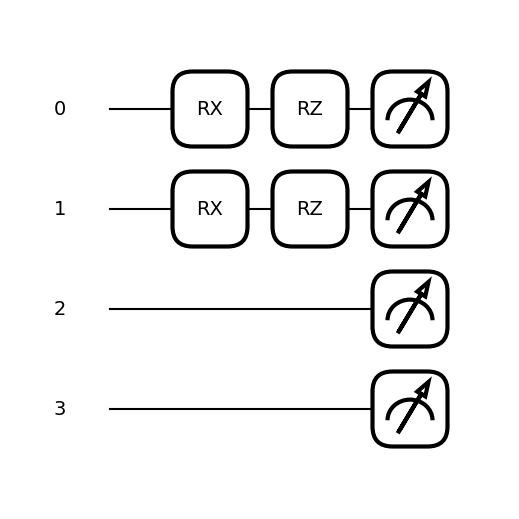

In [302]:
qml.draw_mpl( fun, expansion_strategy ='device' )()

In [283]:
# fun2 = qml.from_qasm( fun.tape.to_openqasm() )
# qml.draw_mpl( fun2 )()

In [284]:
P.pow(3).eigvals()

tensor([ 0.        , -0.83716947,  0.10464618, -0.10464618], requires_grad=True)

In [285]:
np.linalg.eigh( P.matrix() @ P.matrix() @ P.matrix() )[0]

array([-8.37169470e-01, -1.04646184e-01,  1.35561280e-16,  1.04646184e-01])